In [1]:
import os
import torch
os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

In [2]:
cd ..

/home/kgh6784/private/project/instance_segmentation


In [3]:
cd mmdetection

/home/kgh6784/private/project/instance_segmentation/mmdetection


In [4]:
import mmcv
import terminaltables
import pycocotools
from pycocotools.coco import COCO
from mmdet.datasets.builder import DATASETS
from mmdet.datasets import build_dataset
from mmdet.datasets.coco import CocoDataset
from mmdet.models import build_detector
from mmdet.apis import train_detector
from mmdet.apis import init_detector, inference_detector
from mmdet.apis import show_result_pyplot
from mmcv.runner import load_checkpoint
from mmdet.apis import set_random_seed
import mmcv

import torch
import pylab
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
# from requests import get 

# def download(url, file_name):
#     with open(file_name, "wb") as file:   
#         response = get(url)               
#         file.write(response.content)


# url = "https://download.openmmlab.com/mmdetection/v2.0/solov2/solov2_x101_dcn_fpn_3x_coco/solov2_x101_dcn_fpn_3x_coco_20220513_214337-aef41095.pth"
# download(url,"solov2_x101_dcn_fpn_3x_coco_20220513_214337-aef41095.pth")

In [6]:
#py
'solov2_x101_dcn_fpn_3x_coco_20220513_214337-aef41095.pth'
#pth
'./configs/solov2/solov2_x101_dcn_fpn_3x_coco.py'

'./configs/solov2/solov2_x101_dcn_fpn_3x_coco.py'

In [6]:

# 사용할 모데 초기 py 설정
config = '/home/kgh6784/private/project/instance_segmentation/mmdetection/configs/solov2/solov2_x101_dcn_fpn_3x_coco.py'

# config 불러오기
cfg = mmcv.Config.fromfile(config)

# 데이터셋 지정
cfg.dataset_type = 'CocoDataset'

# data_root는 사용자가 저장한 데이터가 있는 폴더 전까지
data_root = '/home/kgh6784/shared/hdd_ext/nvme1/jihun_instance/lg_molecular/dataset/'

# class 설정
cfg.classes = ('Normal',)

# train, val, test 데이터셋에 대한 type, data_root, ann_file, img_prefix 설정

cfg.data.samples_per_gpu=4
cfg.data.workers_per_gpu=2

cfg.data.train.data_root = data_root 
cfg.data.train.ann_file = 'modify2.json' 
#cfg.data.train.ann_file = 'label(polygon)_train.json' 
cfg.data.train.img_prefix = 'train/'
cfg.data.train.classes = cfg.classes



cfg.data.val.data_root = data_root
#cfg.data.val.ann_file = 'label(polygon)_train.json'
cfg.data.train.ann_file = 'modify2.json' 
cfg.data.val.img_prefix = 'train/'
cfg.data.val.classes = cfg.classes

cfg.data.test.data_root = data_root
cfg.data.test.ann_file = 'test.json'
cfg.data.test.img_prefix = 'test/'
cfg.data.test.classes = cfg.classes

#cfg.test_pipeline[1]['flip'] = True


#cfg.data.test.pipeline[1]['flip'] = True
###### TIMM
# print(cfg.custom_imports)
# print(cfg.model.backbone)
# cfg.custom_imports = dict(imports=['mmcls.models'], allow_failed_imports=False)
# cfg.model.backbone = dict(
#         _delete_=True, # Delete the backbone field in _base_
#         type='mmcls.TIMMBackbone', # Using timm from mmcls
#         model_name='resnet101',
#         features_only=True,
#         pretrained=True,
#         out_indices=(1, 2, 3, 4)) #
######

# 클래스 수 지정
# cfg.model.roi_head.bbox_head.num_classes = 1
# cfg.model.roi_head.mask_head.num_classes = 1
cfg.model.mask_head['num_classes'] = 1
# 사전 훈련 모델 지정
cfg.load_from = '/home/kgh6784/private/project/instance_segmentation/mmdetection/solov2_x101_dcn_fpn_3x_coco_20220513_214337-aef41095.pth'
#cfg.resume_from = './work_dirs/lg_cfg2_s2_10_tta/epoch_10.pth'
# 가중치 저장 위치
cfg.work_dir = '/home/kgh6784/private/project/instance_segmentation/mmdetection/work_dirs/lg_cfg2_s2_10_notta_large/'

# learning rate
cfg.optimizer.lr = 0.02 / 8

# 로그 출력 시기 설정
cfg.log_config.interval = 1 
cfg.lr_config.policy = 'step'

# 평가 지표로 설정
cfg.evaluation.metric = ['bbox', 'segm']

# 평가 구간 설정
cfg.evaluation.interval = 10

# 체크포인트 구간 설정
cfg.checkpoint_config.interval = 10

# epoch 설정
cfg.runner = dict(type='EpochBasedRunner', max_epochs=5)
cfg.runner.max_epochs = 10
# 결과 재현을 위한 시드값 설정
cfg.seed = 0
set_random_seed(0, deterministic=False)
cfg.gpu_ids = range(1)
cfg.device='cuda'

In [7]:
cfg.train_pipeline[2]['img_scale'] = (2666, 1600)
cfg.test_pipeline[1]['img_scale'] = (2666, 1600)
cfg.auto_scale_lr = dict(enable=False, base_batch_size=8)

In [23]:
cfg.data.test.pipeline[1]['flip']

True

In [6]:
print(f'Config:\n{cfg.pretty_text}')

Config:
dataset_type = 'CocoDataset'
data_root = 'data/coco/'
img_norm_cfg = dict(
    mean=[123.675, 116.28, 103.53], std=[58.395, 57.12, 57.375], to_rgb=True)
train_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(type='LoadAnnotations', with_bbox=True, with_mask=True),
    dict(
        type='Resize',
        img_scale=[(1333, 800), (1333, 768), (1333, 736), (1333, 704),
                   (1333, 672), (1333, 640)],
        multiscale_mode='value',
        keep_ratio=True),
    dict(type='RandomFlip', flip_ratio=0.5),
    dict(
        type='Normalize',
        mean=[123.675, 116.28, 103.53],
        std=[58.395, 57.12, 57.375],
        to_rgb=True),
    dict(type='Pad', size_divisor=32),
    dict(type='DefaultFormatBundle'),
    dict(type='Collect', keys=['img', 'gt_bboxes', 'gt_labels', 'gt_masks'])
]
test_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(
        type='MultiScaleFlipAug',
        img_scale=(1333, 800),
        flip=True,
        transforms=[
    

In [ ]:
datasets = [build_dataset(cfg.data.train)]
model = build_detector(cfg.model)
model.CLASSES = datasets[0].CLASSES
train_detector(model, datasets, cfg, distributed=False, validate=True)

loading annotations into memory...
Done (t=1.07s)
creating index...
index created!


2022-07-30 08:00:21,398 - mmdet - INFO - Automatic scaling of learning rate (LR) has been disabled.


loading annotations into memory...


2022-07-30 08:00:22,745 - mmdet - INFO - load checkpoint from local path: /home/kgh6784/private/project/instance_segmentation/mmdetection/solov2_x101_dcn_fpn_3x_coco_20220513_214337-aef41095.pth


Done (t=1.17s)
creating index...
index created!


2022-07-30 08:00:23,819 - root - INFO - ModulatedDeformConvPack backbone.layer2.0.conv2 is upgraded to version 2.
2022-07-30 08:00:23,823 - root - INFO - ModulatedDeformConvPack backbone.layer2.1.conv2 is upgraded to version 2.
2022-07-30 08:00:23,827 - root - INFO - ModulatedDeformConvPack backbone.layer2.2.conv2 is upgraded to version 2.
2022-07-30 08:00:23,831 - root - INFO - ModulatedDeformConvPack backbone.layer2.3.conv2 is upgraded to version 2.
2022-07-30 08:00:23,836 - root - INFO - ModulatedDeformConvPack backbone.layer3.0.conv2 is upgraded to version 2.
2022-07-30 08:00:23,845 - root - INFO - ModulatedDeformConvPack backbone.layer3.1.conv2 is upgraded to version 2.
2022-07-30 08:00:23,852 - root - INFO - ModulatedDeformConvPack backbone.layer3.2.conv2 is upgraded to version 2.
2022-07-30 08:00:23,861 - root - INFO - ModulatedDeformConvPack backbone.layer3.3.conv2 is upgraded to version 2.
2022-07-30 08:00:23,869 - root - INFO - ModulatedDeformConvPack backbone.layer3.4.conv2 

/opt/conda/lib/python3.8/site-packages/torch/functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755903507/work/aten/src/ATen/native/TensorShape.cpp:2228.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/home/kgh6784/private/project/instance_segmentation/mmdetection/mmdet/models/dense_heads/solov2_head.py:385: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  (center_w / upsampled_size[1]) // (1. / num_grid))
/home/kgh6784/private/project/instance_segmentation/mmdetection/mmdet/models/dense_heads/solov2_head.py:3

2022-07-30 09:07:38,369 - mmdet - INFO - Epoch [1][23/130]	lr: 9.067e-04, eta: 2 days, 14:13:06, time: 51.468, data_time: 49.183, memory: 16325, loss_mask: 0.7742, loss_cls: 0.2729, loss: 1.0472, grad_norm: 4.0032
2022-07-30 09:07:40,539 - mmdet - INFO - Epoch [1][24/130]	lr: 9.100e-04, eta: 2 days, 11:36:40, time: 2.170, data_time: 0.026, memory: 16325, loss_mask: 0.7102, loss_cls: 0.2529, loss: 0.9631, grad_norm: 3.3855
2022-07-30 09:12:33,660 - mmdet - INFO - Epoch [1][25/130]	lr: 9.133e-04, eta: 2 days, 13:20:04, time: 293.121, data_time: 291.132, memory: 16325, loss_mask: 0.7849, loss_cls: 0.2598, loss: 1.0446, grad_norm: 4.7885
2022-07-30 09:12:35,680 - mmdet - INFO - Epoch [1][26/130]	lr: 9.167e-04, eta: 2 days, 10:57:24, time: 2.020, data_time: 0.024, memory: 16325, loss_mask: 0.7251, loss_cls: 0.2468, loss: 0.9719, grad_norm: 3.7756
2022-07-30 09:20:53,946 - mmdet - INFO - Epoch [1][27/130]	lr: 9.200e-04, eta: 2 days, 15:15:15, time: 498.266, data_time: 496.169, memory: 16325,

/home/kgh6784/private/project/instance_segmentation/mmdetection/mmdet/datasets/utils.py:66: UserWarning: "ImageToTensor" pipeline is replaced by "DefaultFormatBundle" for batch inference. It is recommended to manually replace it in the test data pipeline in your config file.
  warnings.warn(


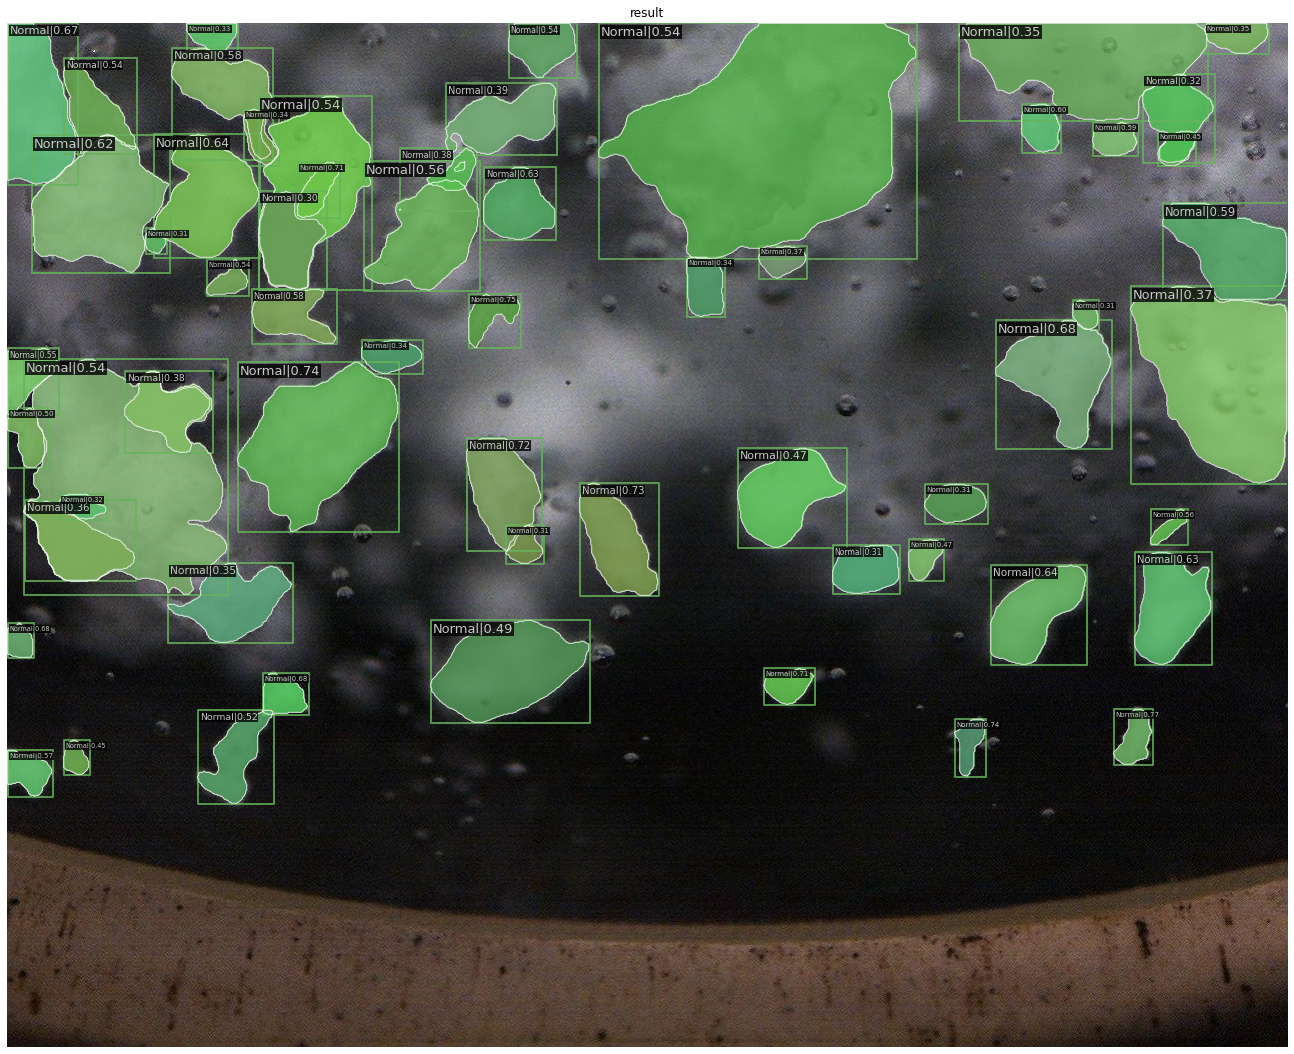

In [9]:
img = mmcv.imread('/home/kgh6784/shared/hdd_ext/nvme1/jihun_instance/lg_molecular/dataset/test/0087.jpg')

model.cfg = cfg
result = inference_detector(model, img)
show_result_pyplot(model, img, result)

In [13]:
result

([array([[0.        , 0.        , 0.        , 0.        , 0.8385008 ],
         [0.        , 0.        , 0.        , 0.        , 0.8230317 ],
         [0.        , 0.        , 0.        , 0.        , 0.79766923],
         [0.        , 0.        , 0.        , 0.        , 0.77947825],
         [0.        , 0.        , 0.        , 0.        , 0.77741486],
         [0.        , 0.        , 0.        , 0.        , 0.77677596],
         [0.        , 0.        , 0.        , 0.        , 0.7716012 ],
         [0.        , 0.        , 0.        , 0.        , 0.7644121 ],
         [0.        , 0.        , 0.        , 0.        , 0.7615943 ],
         [0.        , 0.        , 0.        , 0.        , 0.7565276 ],
         [0.        , 0.        , 0.        , 0.        , 0.75050175],
         [0.        , 0.        , 0.        , 0.        , 0.74941707],
         [0.        , 0.        , 0.        , 0.        , 0.7298118 ],
         [0.        , 0.        , 0.        , 0.        , 0.7213958 ],
      

In [ ]:
model.backbone.relu = nn.functional.relu6(inplace=True)

In [11]:
!python /home/kgh6784/private/project/instance_segmentation/mmdetection/test.py /home/kgh6784/private/project/instance_segmentation/mmdetection/configs/custom/lg_mask_solov2.py /home/kgh6784/private/project/instance_segmentation/mmdetection/work_dirs/lg_cfg2_s2_10_tta2/latest.pth --format-only --eval-options "jsonfile_prefix=/home/kgh6784/private/project/instance_segmentation/mmdetection/work_dirs/lg_cfg2_s2_10_notta_large/"

/home/kgh6784/private/project/instance_segmentation/mmdetection/mmdet/utils/setup_env.py:38: UserWarning: Setting OMP_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed.
  warnings.warn(
/home/kgh6784/private/project/instance_segmentation/mmdetection/mmdet/utils/setup_env.py:48: UserWarning: Setting MKL_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed.
  warnings.warn(
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
load checkpoint from local path: /home/kgh6784/private/project/instance_segmentation/mmdetection/work_dirs/lg_cfg2_s2_10_tta2/latest.pth
2022-08-01 16:03:16,388 - root - INFO - ModulatedDeformConvPack backbone.layer2.0.conv2 is upgraded to version 2.
20